# Sri Lanka Small Tanks Sendimentation Modeling

data source: UNDP small tanks survey

last modified: 2023/12/19

In [1]:
import os
import sys
from hashlib import sha1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split,
    RandomizedSearchCV,
)

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, KBinsDiscretizer
from sklearn.feature_selection import SelectFromModel

from sklearn.svm import SVC, SVR
from lightgbm.sklearn import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
import shap

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Import and split data

In [3]:
#tank_df = pd.read_excel('/kaggle/input/undp-small-tanks-sendimentation3/undp_small_tanks_sendimentation_ml.xlsx')
tank_df = pd.read_excel('data/undp_small_tanks_sendimentation_ml.xlsx')
tank_df.head()

,map_id,tank_owner,functional,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,...,has_2_func_sluice,has_spill,has_2_spill,silt,poly,no_neighbors,cascade,renovat,num_slu,soil
0,18,DAD,Functioning,7642.616211,6110.480469,5189.187988,5033.489258,5853.970703,6491.962891,5696.561035,...,0,1,0,less than 1 ft,1,1.0,0.0,0.0,1,"Noncalcic Brown soils, soils on old alluvium &..."
1,25,DAD,Functioning,7218.720215,6200.347656,4881.518555,4558.301270,4658.052734,5147.490234,5143.641113,...,0,1,0,less than 1 ft,1,16.0,0.0,0.0,1,Noncalcic Brown soils & Low Humic Gley soils; ...
2,26,DAD,Functioning,7026.510742,6043.844238,4861.998047,4527.718262,4617.099121,5060.282227,5067.521484,...,0,1,0,less than 1 ft,1,17.0,0.0,0.0,1,Noncalcic Brown soils & Low Humic Gley soils; ...
3,28,DAD,Functioning,6575.861328,5811.095703,5302.811523,5144.025879,5558.791016,5985.856445,5473.228516,...,0,1,0,less than 1 ft,1,8.0,0.0,0.0,0,Regosols on Recent beach and dune sands; flat ...
4,122,DAD,Functioning,7861.033203,7740.585449,6765.989258,6530.480469,6500.167969,6573.558105,6044.023438,...,1,1,0,more than 3 ft,1,3.0,0.0,1.0,2,Reddish Brown Earths & Low Humic Gley soils; u...


In [4]:
tank_df = tank_df.rename(columns={'silt': 'Target'})

target_mapping = {
    "less than 1 ft": 0,
    "1-3 ft": 1,
    "more than 3 ft": 2
}

tank_df['Target'] = tank_df['Target'].replace(target_mapping)
tank_df['Target'].value_counts(normalize=True)

Target
2    0.410205
1    0.401701
0    0.188095
Name: proportion, dtype: float64

In [5]:
train_df, test_df = train_test_split(tank_df, test_size=0.2, random_state=123, stratify=tank_df['Target'])
train_df.shape, test_df.shape

((5550, 78), (1388, 78))

In [6]:
train_df["Target"].value_counts(normalize=True)

Target
2    0.410270
1    0.401622
0    0.188108
Name: proportion, dtype: float64

## Preprocessing and metrics selection

In [7]:
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro'),
}


In [8]:
X_train = train_df.drop(columns=['Target'])
y_train = train_df['Target']
X_test = test_df.drop(columns=['Target'])
y_test = test_df['Target']

In [9]:
numeric_features = ['ndvi201701_1', 'ndvi201702_1', 'ndvi201703_1', 'ndvi201704_1', 'ndvi201705_1', 'ndvi201706_1',
                   'ndvi201707_1', 'ndvi201708_1', 'ndvi201709_1', 'ndvi201710_1', 'ndvi201711_1', 'ndvi201712_1', 
                   'chirps201701_1', 'chirps201702_1', 'chirps201703_1', 'chirps201704_1', 'chirps201705_1', 'chirps201706_1',
                   'chirps201707_1', 'chirps201708_1', 'chirps201709_1', 'chirps2017010_1', 'chirps201711_1', 'chirps201712_1',
                   'lst201701_1', 'lst201702_1', 'lst201703_1', 'lst201704_1', 'lst201705_1', 'lst201706_1',
                   'lst201707_1', 'lst201708_1', 'lst201709_1', 'lst201710_1', 'lst201711_1', 'lst201712_1',
                   'chirps_mean', 'chirps_std', 'lst_mean', 'lst_std', 'ndvi_mean', 'ndvi_std', 
                   'chirps_cv', 'lst_cv', 'ndvi_cv', 
                   'wsa', 'slope_dem_1','gw_risk', 'no_neighbors']
binary_features = ['_4_1irrigatedagriculture', '_4_2fishing', '_4_3livestock', '_4_4daytodayuse', '_4_5smallscaleindustries', '_4_6environmentaluse', '_4_7ecotourism', '_4_8other',
                   '_5_2_1breached', '_5_2_1_1needrenovations', '_5_2_2goodcondition', '_5_2_3tankbundrehabilitated',
                   'has_func_sluice', 'has_2_func_sluice', 'has_spill', 'has_2_spill', 'poly', 'cascade', 'renovat']
categorical_features = ['soil', 'aquname', 'aquifer', 'tank_ownership', 'functional']
ordinal_features = ['num_slu']

drop_features = ['map_id', 'tank_owner', '_6numberoffunctionalsluices']

In [10]:
print(len(numeric_features) + len(binary_features) + len(categorical_features) + len(drop_features))

76


In [11]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),

        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop="if_binary"))
        ]), categorical_features + binary_features),

        ("ord", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OrdinalEncoder(dtype=np.int64, handle_unknown='use_encoded_value', unknown_value=-1))
        ]), ordinal_features),
        ("drop", 'drop', drop_features)
    ]
)

In [12]:
preprocessor.fit(X_train, y_train)
onehot_feature_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features + binary_features)

feature_names = (
    numeric_features
    + ordinal_features
    + preprocessor.named_transformers_['cat']['encoder']
    .get_feature_names_out(categorical_features + binary_features)
    .tolist()
)

In [13]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

results = {}

## Modeling

### Baselines

In [14]:
dummy = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy
fit_time,0.001 (+/- 0.001)
score_time,0.004 (+/- 0.001)
test_accuracy,0.362 (+/- 0.009)
train_accuracy,0.371 (+/- 0.003)
test_precision_macro,0.332 (+/- 0.010)
train_precision_macro,0.339 (+/- 0.004)
test_recall_macro,0.332 (+/- 0.010)
train_recall_macro,0.339 (+/- 0.004)
test_f1_macro,0.332 (+/- 0.009)
train_f1_macro,0.339 (+/- 0.004)


In [15]:
pipe_dt = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=123, class_weight='balanced', max_depth=3)
)

# Get cross-validation scores for the decision tree
results["decision_tree"] = mean_std_cross_val_scores(
    pipe_dt, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy,decision_tree
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011)


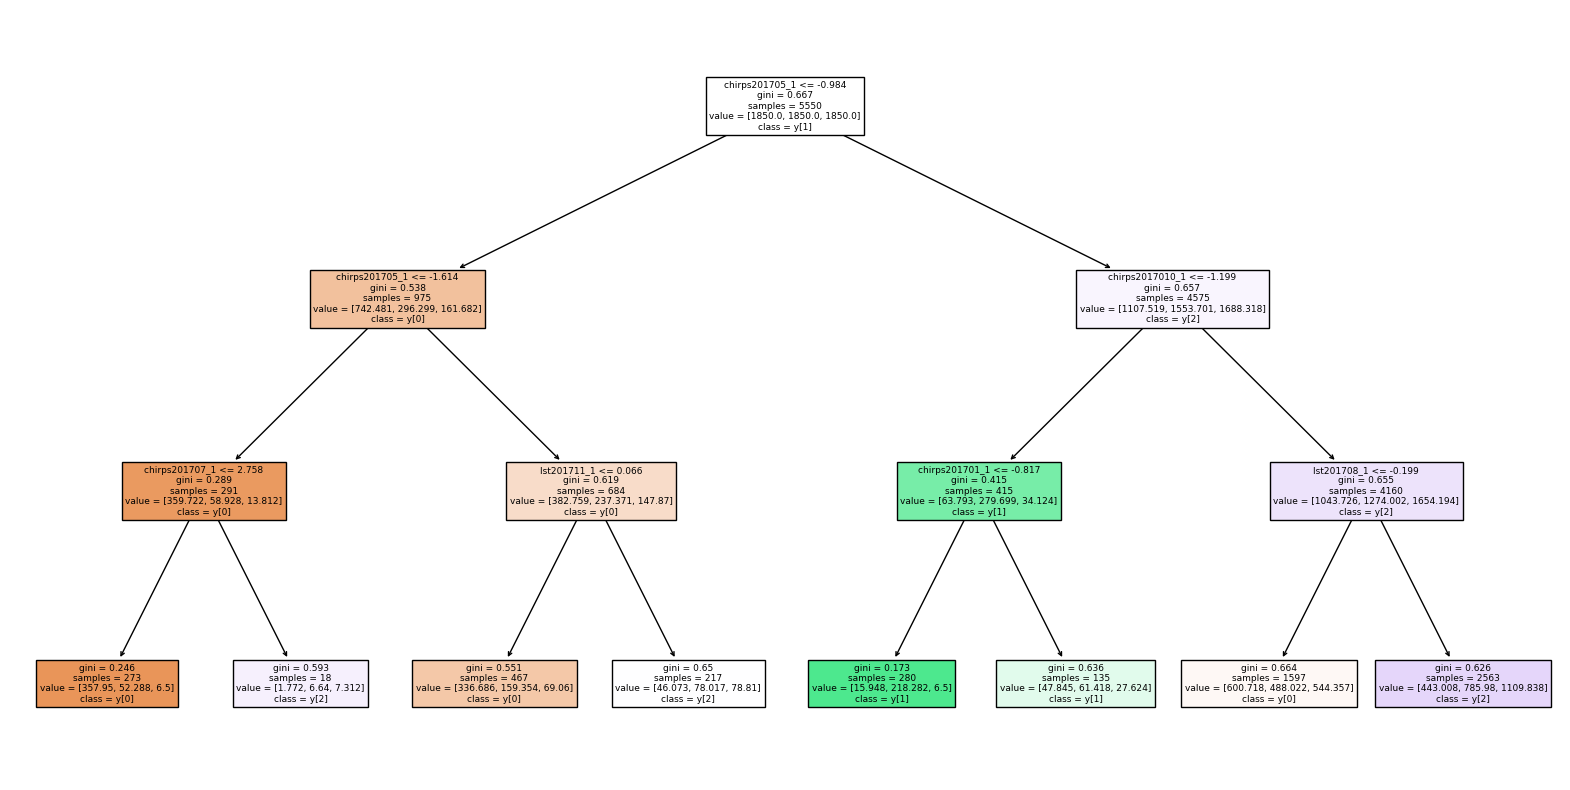

In [16]:
pipe_dt.fit(X_train, y_train)

# Get the fitted decision tree classifier from the pipeline
fitted_tree = pipe_dt.named_steps['decisiontreeclassifier']

# Plot the decision tree
plt.figure(figsize=(20,10))
plot_tree(fitted_tree, filled=True, feature_names=feature_names, class_names=True)
plt.show()

In [17]:
pipe_lr = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=2000, random_state=123, class_weight="balanced", multi_class='multinomial', solver='lbfgs')
)

results["logreg"] = mean_std_cross_val_scores(
    pipe_lr, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

pd.DataFrame(results)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


,dummy,decision_tree,logreg
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006)


In [18]:
pipe_lr.fit(X_train, y_train)

# Make predictions
y_pred = pipe_lr.predict(X_test)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Generate classification report
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

Confusion Matrix:
 [[148  44  69]
 [130 201 227]
 [109 106 354]]

Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.57      0.46       261
           1       0.57      0.36      0.44       558
           2       0.54      0.62      0.58       569

    accuracy                           0.51      1388
   macro avg       0.50      0.52      0.49      1388
weighted avg       0.53      0.51      0.50      1388



### SVM, KNN, Ridge, Random Forst, XGBoost and LGBM

In [19]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

#le = LabelEncoder()
#y_train_encoded = le.fit_transform(y_train)
#y_test_encoded = le.transform(y_test) 

In [20]:
models = {
    "SVM Poly": SVC(kernel='poly', decision_function_shape='ovo', class_weight='balanced', probability=True),
    "knn": KNeighborsClassifier(n_neighbors=5), 
    "ridge": RidgeClassifier(random_state=123),
    "random forest": RandomForestClassifier(class_weight=class_weights_dict, random_state=123, n_jobs=-1),
    "xgboost": XGBClassifier(objective='multi:softprob', random_state=123, n_jobs=-1), 
    "lgbm": LGBMClassifier(objective='multiclass', random_state=123, verbosity=-1, n_jobs=-1),
}

for name, model in models.items():
    pipe = make_pipeline(preprocessor, model)
    results[name] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is dep

In [21]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052),4.101 (+/- 0.283),0.099 (+/- 0.023),0.073 (+/- 0.020),0.789 (+/- 0.013),2.435 (+/- 0.392),1.422 (+/- 0.189)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001),0.116 (+/- 0.004),0.070 (+/- 0.092),0.013 (+/- 0.001),0.043 (+/- 0.001),0.043 (+/- 0.019),0.042 (+/- 0.006)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003)


In [22]:
for name, model in models.items():
    pipe = make_pipeline(
        preprocessor,
        SelectFromModel(
            LogisticRegression(solver="liblinear", penalty="l1", max_iter=1000)
        ),
        model,
    )
    results[name + "+ FS"] = mean_std_cross_val_scores(
        pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is dep

In [23]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,SVM Poly+ FS,knn+ FS,ridge+ FS,random forest+ FS,xgboost+ FS,lgbm+ FS
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052),4.101 (+/- 0.283),0.099 (+/- 0.023),0.073 (+/- 0.020),0.789 (+/- 0.013),2.435 (+/- 0.392),1.422 (+/- 0.189),5.058 (+/- 0.343),0.770 (+/- 0.099),0.800 (+/- 0.165),1.665 (+/- 0.110),3.307 (+/- 0.096),2.078 (+/- 0.241)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001),0.116 (+/- 0.004),0.070 (+/- 0.092),0.013 (+/- 0.001),0.043 (+/- 0.001),0.043 (+/- 0.019),0.042 (+/- 0.006),0.119 (+/- 0.003),0.076 (+/- 0.029),0.016 (+/- 0.001),0.067 (+/- 0.005),0.046 (+/- 0.007),0.041 (+/- 0.007)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.560 (+/- 0.020),0.588 (+/- 0.014),0.534 (+/- 0.017),0.705 (+/- 0.017),0.682 (+/- 0.008),0.667 (+/- 0.015)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.639 (+/- 0.006),0.735 (+/- 0.006),0.558 (+/- 0.004),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.002)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.564 (+/- 0.020),0.578 (+/- 0.015),0.561 (+/- 0.028),0.710 (+/- 0.018),0.685 (+/- 0.012),0.676 (+/- 0.018)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.661 (+/- 0.007),0.726 (+/- 0.007),0.595 (+/- 0.009),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.002)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.557 (+/- 0.020),0.577 (+/- 0.016),0.488 (+/- 0.019),0.681 (+/- 0.019),0.656 (+/- 0.010),0.643 (+/- 0.017)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.642 (+/- 0.006),0.725 (+/- 0.005),0.512 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.969 (+/- 0.002)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.541 (+/- 0.022),0.577 (+/- 0.015),0.495 (+/- 0.022),0.692 (+/- 0.019),0.666 (+/- 0.011),0.654 (+/- 0.017)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.629 (+/- 0.007),0.725 (+/- 0.006),0.522 (+/- 0.007),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.002)


In [24]:
# drop FS models from the results dataframe
keys_to_remove = [key for key in results if '+ FS' in key]
for key in keys_to_remove:
    del results[key]

In [25]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052),4.101 (+/- 0.283),0.099 (+/- 0.023),0.073 (+/- 0.020),0.789 (+/- 0.013),2.435 (+/- 0.392),1.422 (+/- 0.189)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001),0.116 (+/- 0.004),0.070 (+/- 0.092),0.013 (+/- 0.001),0.043 (+/- 0.001),0.043 (+/- 0.019),0.042 (+/- 0.006)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003)


## Hyperparameter tuning

In [26]:
scoring_metric = make_scorer(f1_score, average="macro")

In [27]:
param_grid_rf = {
    "randomforestclassifier__n_estimators": randint(low=10, high=100),
    "randomforestclassifier__max_depth": randint(low=2, high=20),
    "randomforestclassifier__class_weight": [class_weights_dict, None]
}

pipe_random_forest = make_pipeline(preprocessor, models["random forest"])

In [28]:
random_search_rf = RandomizedSearchCV(
    pipe_random_forest,
    param_grid_rf,
    n_iter=50,
    n_jobs=-1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_rf.fit(X_train, y_train)
print("Best hyperparameter values: ", random_search_rf.best_params_)
print("Best score: %0.3f" % (random_search_rf.best_score_))

Best hyperparameter values:  {'randomforestclassifier__class_weight': {0: 1.7720306513409962, 1: 0.8299685957828623, 2: 0.8124725516029864}, 'randomforestclassifier__max_depth': 19, 'randomforestclassifier__n_estimators': 96}
Best score: 0.693


In [29]:
pd.DataFrame(random_search_rf.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_randomforestclassifier__n_estimators",
        "param_randomforestclassifier__max_depth",
        "mean_fit_time",
        "rank_test_score",
        "std_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_randomforestclassifier__n_estimators,param_randomforestclassifier__max_depth,mean_fit_time,std_test_score
rank_test_score,,,,,,
1,0.999381,0.692784,96,19,6.037548,0.015211
2,0.998740,0.682107,78,18,4.114988,0.008452
3,0.988552,0.681517,93,16,4.166434,0.019699
4,0.997215,0.680940,71,17,4.074545,0.015941
5,0.997193,0.680539,69,17,4.965873,0.015621
6,0.984920,0.679364,46,16,2.239422,0.021190
7,0.992433,0.679137,87,15,4.547226,0.012064
8,0.987535,0.678242,84,16,4.210421,0.017893
9,0.991565,0.677814,76,15,4.324671,0.015540


In [30]:
best_rf_model = random_search_rf.best_estimator_
results["random forest (tuned)"] = mean_std_cross_val_scores(
    best_rf_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [31]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,random forest (tuned)
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052),4.101 (+/- 0.283),0.099 (+/- 0.023),0.073 (+/- 0.020),0.789 (+/- 0.013),2.435 (+/- 0.392),1.422 (+/- 0.189),0.880 (+/- 0.036)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001),0.116 (+/- 0.004),0.070 (+/- 0.092),0.013 (+/- 0.001),0.043 (+/- 0.001),0.043 (+/- 0.019),0.042 (+/- 0.006),0.069 (+/- 0.006)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.706 (+/- 0.016)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.999 (+/- 0.000)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.710 (+/- 0.014)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.999 (+/- 0.000)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.683 (+/- 0.018)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.999 (+/- 0.000)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.693 (+/- 0.017)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.999 (+/- 0.000)


In [32]:
param_grid_lgbm = {
    "lgbmclassifier__n_estimators": randint(10, 100),
    "lgbmclassifier__max_depth": randint(low=2, high=20),
    "lgbmclassifier__learning_rate": [0.01, 0.1],
    "lgbmclassifier__subsample": [0.5, 0.75, 1],
}

pipe_lgbm = make_pipeline(
    preprocessor,
    models["lgbm"],
)

In [33]:
random_search_lgbm = RandomizedSearchCV(
    pipe_lgbm,
    param_grid_lgbm,
    n_iter=50,
    n_jobs=-1,
    scoring=scoring_metric,
    random_state=123,
    return_train_score=True,
)

random_search_lgbm.fit(X_train, y_train)
print("Best hyperparameter values: ", random_search_lgbm.best_params_)
print("Best score: %.3f" % (random_search_lgbm.best_score_))

Best hyperparameter values:  {'lgbmclassifier__learning_rate': 0.1, 'lgbmclassifier__max_depth': 19, 'lgbmclassifier__n_estimators': 96, 'lgbmclassifier__subsample': 0.75}
Best score: 0.655


In [34]:
pd.DataFrame(random_search_lgbm.cv_results_)[
    [
        "mean_train_score",
        "mean_test_score",
        "param_lgbmclassifier__n_estimators",
        "param_lgbmclassifier__learning_rate",
        "param_lgbmclassifier__subsample",
        "mean_fit_time",
        "rank_test_score",
    ]
].set_index("rank_test_score").sort_index()[:10]

,mean_train_score,mean_test_score,param_lgbmclassifier__n_estimators,param_lgbmclassifier__learning_rate,param_lgbmclassifier__subsample,mean_fit_time
rank_test_score,,,,,,
1,0.969117,0.655341,96,0.1,0.75,17.336684
2,0.958208,0.653524,98,0.1,1,16.335588
3,0.949530,0.652148,95,0.1,1,15.152489
4,0.945056,0.651206,79,0.1,0.5,14.189658
5,0.901029,0.648909,58,0.1,0.5,10.512492
6,0.936372,0.647697,73,0.1,0.5,13.491460
7,0.919634,0.647674,64,0.1,0.75,11.387332
8,0.923695,0.645675,66,0.1,0.5,9.268626
9,0.908284,0.645004,90,0.1,0.5,11.808079


In [35]:
best_lgbm_model = random_search_lgbm.best_estimator_
results["lgbm (tuned)"] = mean_std_cross_val_scores(
    best_lgbm_model, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)


Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [36]:
pd.DataFrame(results)

,dummy,decision_tree,logreg,SVM Poly,knn,ridge,random forest,xgboost,lgbm,random forest (tuned),lgbm (tuned)
fit_time,0.001 (+/- 0.001),0.208 (+/- 0.022),0.456 (+/- 0.052),4.101 (+/- 0.283),0.099 (+/- 0.023),0.073 (+/- 0.020),0.789 (+/- 0.013),2.435 (+/- 0.392),1.422 (+/- 0.189),0.880 (+/- 0.036),1.317 (+/- 0.168)
score_time,0.004 (+/- 0.001),0.014 (+/- 0.002),0.015 (+/- 0.001),0.116 (+/- 0.004),0.070 (+/- 0.092),0.013 (+/- 0.001),0.043 (+/- 0.001),0.043 (+/- 0.019),0.042 (+/- 0.006),0.069 (+/- 0.006),0.043 (+/- 0.008)
test_accuracy,0.362 (+/- 0.009),0.444 (+/- 0.020),0.502 (+/- 0.015),0.561 (+/- 0.021),0.591 (+/- 0.016),0.534 (+/- 0.017),0.704 (+/- 0.011),0.680 (+/- 0.019),0.671 (+/- 0.016),0.706 (+/- 0.016),0.670 (+/- 0.018)
train_accuracy,0.371 (+/- 0.003),0.458 (+/- 0.007),0.532 (+/- 0.006),0.637 (+/- 0.007),0.735 (+/- 0.006),0.560 (+/- 0.003),1.000 (+/- 0.000),0.999 (+/- 0.000),0.973 (+/- 0.003),0.999 (+/- 0.000),0.970 (+/- 0.003)
test_precision_macro,0.332 (+/- 0.010),0.519 (+/- 0.030),0.493 (+/- 0.017),0.565 (+/- 0.021),0.581 (+/- 0.017),0.563 (+/- 0.029),0.710 (+/- 0.010),0.690 (+/- 0.020),0.678 (+/- 0.014),0.710 (+/- 0.014),0.677 (+/- 0.018)
train_precision_macro,0.339 (+/- 0.004),0.543 (+/- 0.027),0.526 (+/- 0.006),0.659 (+/- 0.008),0.726 (+/- 0.006),0.597 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.977 (+/- 0.003),0.999 (+/- 0.000),0.974 (+/- 0.003)
test_recall_macro,0.332 (+/- 0.010),0.485 (+/- 0.021),0.509 (+/- 0.019),0.556 (+/- 0.020),0.580 (+/- 0.018),0.489 (+/- 0.020),0.681 (+/- 0.013),0.657 (+/- 0.023),0.646 (+/- 0.017),0.683 (+/- 0.018),0.644 (+/- 0.021)
train_recall_macro,0.339 (+/- 0.004),0.500 (+/- 0.004),0.544 (+/- 0.005),0.640 (+/- 0.007),0.726 (+/- 0.005),0.514 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.968 (+/- 0.004),0.999 (+/- 0.000),0.965 (+/- 0.003)
test_f1_macro,0.332 (+/- 0.009),0.413 (+/- 0.028),0.490 (+/- 0.017),0.541 (+/- 0.023),0.580 (+/- 0.017),0.495 (+/- 0.024),0.691 (+/- 0.012),0.669 (+/- 0.022),0.657 (+/- 0.016),0.693 (+/- 0.017),0.655 (+/- 0.020)
train_f1_macro,0.339 (+/- 0.004),0.426 (+/- 0.011),0.522 (+/- 0.006),0.627 (+/- 0.008),0.726 (+/- 0.005),0.524 (+/- 0.006),1.000 (+/- 0.000),0.999 (+/- 0.000),0.972 (+/- 0.003),0.999 (+/- 0.000),0.969 (+/- 0.003)


## Feature importance and SHAPLEY values

In [37]:
import shap

X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

X_train_enc.head()

,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,ndvi201708_1,ndvi201709_1,ndvi201710_1,...,_5_2_1_1needrenovations_1.0,_5_2_2goodcondition_1.0,_5_2_3tankbundrehabilitated_1.0,has_func_sluice_1,has_2_func_sluice_1,has_spill_1,has_2_spill_1,poly_1,cascade_1.0,renovat_1.0
887,1.173561,0.948112,1.649697,-0.117696,-0.372231,-0.441112,-0.782639,1.263037,1.566965,0.280738,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6396,0.571111,0.706642,0.668173,1.073230,0.759331,-0.476085,-0.418599,-0.279955,-0.529489,0.269971,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
1208,0.309826,-0.220859,-0.624946,-1.031780,-0.352526,-0.723178,-0.356072,1.045771,0.478928,-1.576097,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0
3711,-0.353669,-0.333149,-0.701696,0.448353,0.642787,0.158730,-0.193749,-1.081107,-0.629006,0.456566,...,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0
1388,-1.391546,-0.261106,-0.765381,-0.197210,-0.746239,-1.079949,-0.334856,-0.305635,-1.448924,-0.606337,...,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0


In [38]:
best_params = random_search_rf.best_params_

best_rf_model = RandomForestClassifier(
    n_estimators=best_params['randomforestclassifier__n_estimators'],
    max_depth=best_params['randomforestclassifier__max_depth'],
    class_weight=best_params['randomforestclassifier__class_weight'],
    random_state=123, 
    n_jobs=-1
)

best_rf_model.fit(X_train_enc, y_train)
best_rf_explainer = shap.TreeExplainer(best_rf_model)
best_rf_shap_values = best_rf_explainer.shap_values(X_train_enc)

In [39]:
values = np.abs(best_rf_shap_values[0]).mean(0)
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:15]

,SHAP
chirps201705_1,0.021814
chirps201706_1,0.016071
chirps201703_1,0.013965
lst201703_1,0.012131
chirps201702_1,0.010980
chirps201704_1,0.010200
chirps2017010_1,0.009626
lst201701_1,0.009390
chirps201701_1,0.009385
chirps_mean,0.008752


In [40]:
pd.DataFrame(data=values, index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[-15:]

,SHAP
tank_ownership_Forest/ Wildlife,2.470644e-05
soil_Reddish Brown Earths & Solodized Solonetz; undulating terrain,2.463295e-05
soil_Red-Yellow Podzolic soils & Mountain Regosols; mountainous terrain,1.608612e-05
soil_Alluvial soils of variable drainage and texture; flat terrain,1.569101e-05
aquifer_Shallow alluvial aquifer,1.499269e-05
"soil_Reddish Brown Latosolic soils; steeply dissected, hilly and rolling terrain",1.485118e-05
aquname_Shallow alluvial aquifer,1.335984e-05
"soil_Red-Yellow Podzolic soils; steeply dissected, hilly and rolling terrain",1.090764e-05
"soil_Reddish Brown Earths, Noncalcic Brown soils & Low Humic Gley soils; undulating terrain",1.084160e-05
aquifer_Basement regolith aquifer,9.443013e-06


In [41]:
best_rf_explanation = best_rf_explainer(X_train_enc)

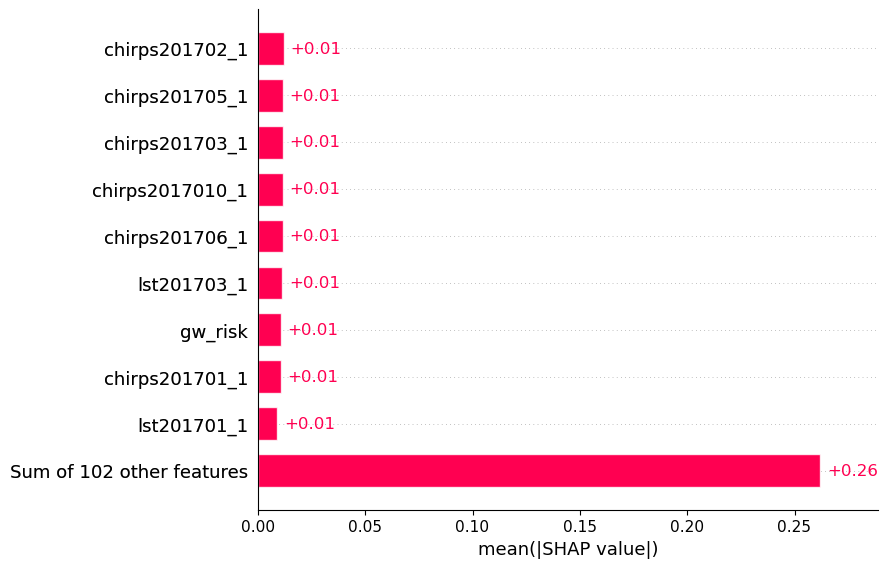

In [42]:
shap.plots.bar(best_rf_explanation[:, :, 1])

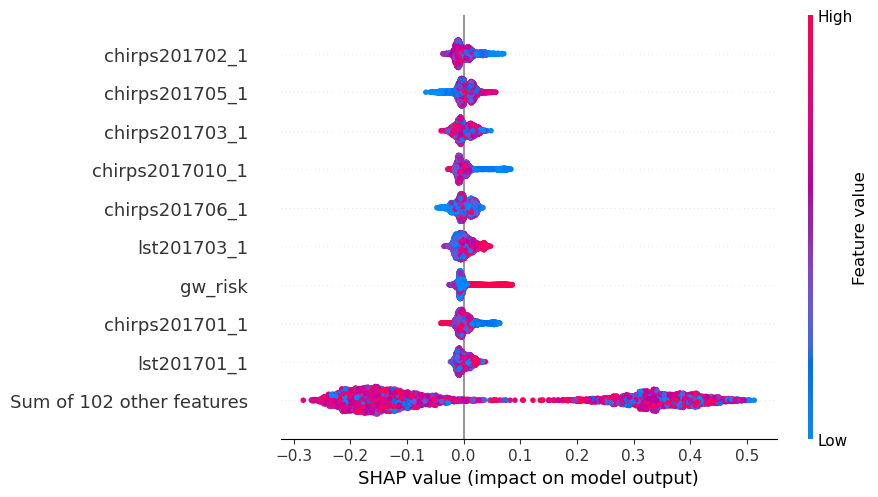

In [43]:
shap.plots.beeswarm(best_rf_explanation[:, :, 1])

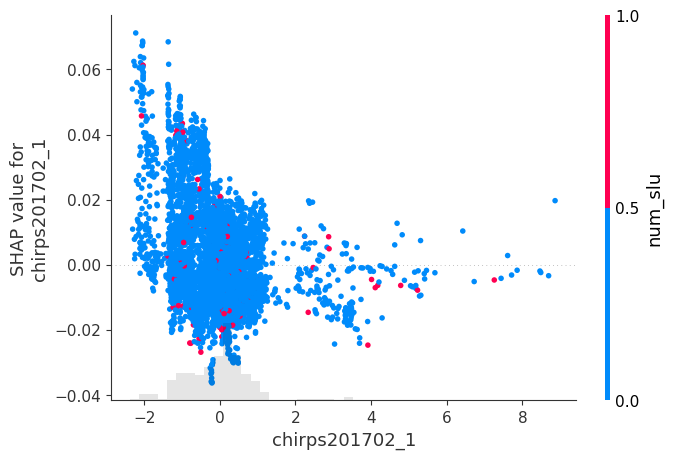

In [44]:
shap.plots.scatter(
    best_rf_explanation[:, 'chirps201702_1', 1],
    best_rf_explanation[:, 'num_slu', 1],   
)

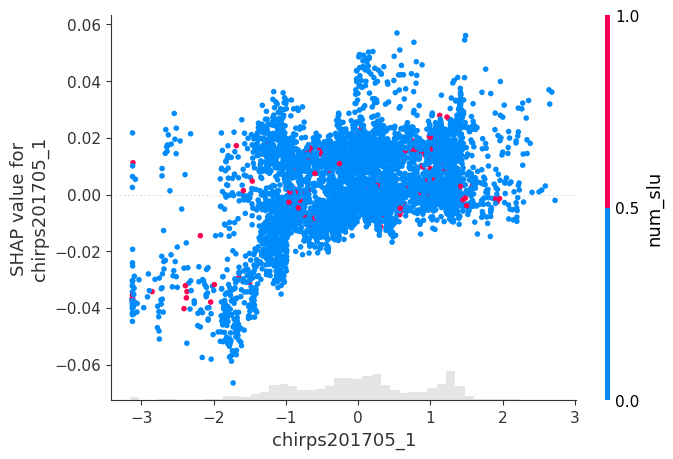

In [45]:
shap.plots.scatter(
    best_rf_explanation[:, 'chirps201705_1', 1],
    best_rf_explanation[:, 'num_slu', 1],   
)

## Prediction explaination

In [46]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)

In [47]:
best_rf_model.predict_proba(X_test_enc)[100]

array([0.07911263, 0.59329114, 0.32759623])

In [48]:
best_rf_explainer.expected_value

array([0.33131497, 0.33409867, 0.33458636])

In [49]:
test_rf_explanation = best_rf_explainer(X_test_enc)

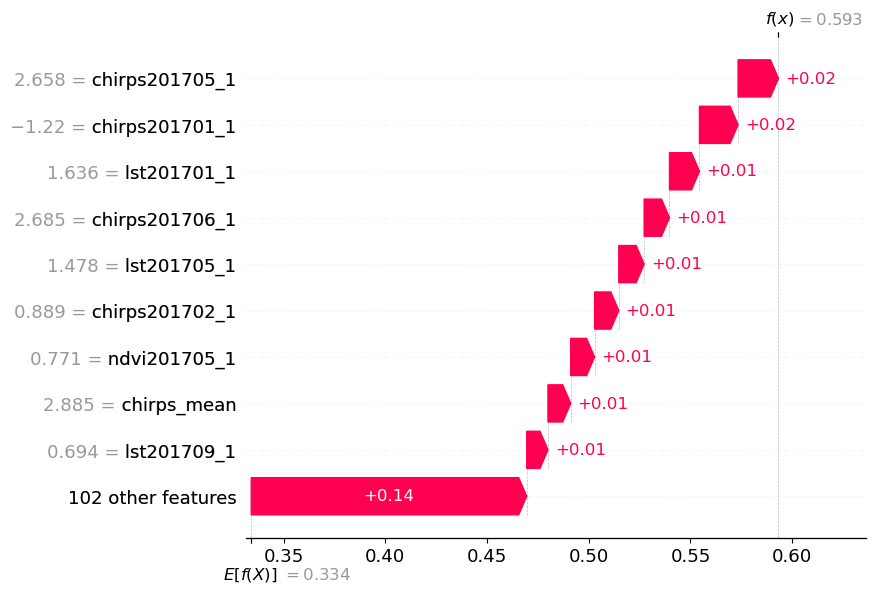

In [50]:
shap.plots.waterfall(test_rf_explanation[100, :, 1])

In [51]:
best_rf_model.predict_proba(X_test_enc)[200]

array([0.07097282, 0.28590103, 0.64312615])

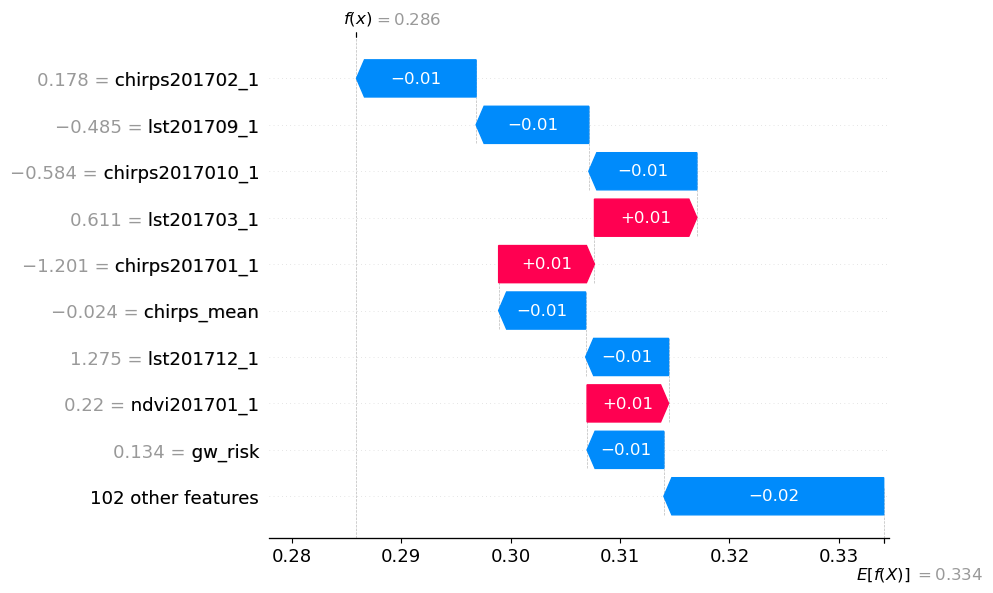

In [52]:
shap.plots.waterfall(test_rf_explanation[200, :, 1])

## Performance on test data

In [53]:
best_rf_model.fit(X_train_enc, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test_enc)

print(
    "Macro-average f1 score on the test set: %0.3f"
    % (f1_score(y_test, y_pred, average="macro"))
)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

Macro-average f1 score on the test set: 0.709
Confusion Matrix:
 [[151  56  54]
 [ 37 400 121]
 [ 23  88 458]]

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64       261
           1       0.74      0.72      0.73       558
           2       0.72      0.80      0.76       569

    accuracy                           0.73      1388
   macro avg       0.72      0.70      0.71      1388
weighted avg       0.73      0.73      0.72      1388



## Deployment

In [54]:
X_deploy = pd.read_excel('data/undp_small_tanks_sendimentation_predict.xlsx')
X_deploy.head()

,map_id,tank_owner,functional,ndvi201701_1,ndvi201702_1,ndvi201703_1,ndvi201704_1,ndvi201705_1,ndvi201706_1,ndvi201707_1,...,has_2_func_sluice,has_spill,has_2_spill,silt,poly,no_neighbors,cascade,renovat,num_slu,soil
0,15,DAD,Abandoned,7687.636719,5552.469238,4618.281250,4482.211426,5620.000000,6885.631836,5545.787598,...,0,1,0,NaN,1,0.0,0.0,0.0,0,"Noncalcic Brown soils, soils on old alluvium &..."
1,16,DAD,Functioning,6913.036133,5359.130371,4990.562012,4914.244629,5465.482910,6484.871094,5265.929688,...,1,1,1,NaN,1,0.0,0.0,1.0,2,"Noncalcic Brown soils, soils on old alluvium &..."
2,17,DAD,Abandoned,7205.619141,5416.968262,4933.405762,4813.590820,5489.919434,6615.495117,5330.633789,...,0,1,0,NaN,1,0.0,0.0,0.0,0,"Noncalcic Brown soils, soils on old alluvium &..."
3,21,DAD,Functioning,7445.786621,6612.575684,6011.904297,5710.815918,5778.194336,6089.119629,5609.558105,...,1,1,0,NaN,1,1.0,0.0,1.0,2,Noncalcic Brown soils & Low Humic Gley soils; ...
4,41,DAD,Functioning,8227.513672,7937.765625,6693.825195,6578.534668,6791.583008,7627.004883,8033.291992,...,0,1,0,NaN,1,1.0,0.0,0.0,1,Alluvial soils of variable drainage and textur...


In [55]:
X_deploy_enc = pd.DataFrame(
    data=preprocessor.transform(X_deploy),
    columns=feature_names,
    index=X_deploy.index,
)

#y_deploy = pd.DataFrame(best_rf_model.predict(X_deploy_enc))

#y_deploy
X_deploy['predicted_target'] = best_rf_model.predict(X_deploy_enc)

Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros


In [56]:
X_deploy['predicted_target'].value_counts()

predicted_target
1    2998
0    2739
2    1836
Name: count, dtype: int64

In [57]:
best_rf_model.predict_proba(X_deploy_enc)[100]

array([0.21875   , 0.30208333, 0.47916667])

In [58]:
deploy_rf_explanation = best_rf_explainer(X_deploy_enc)

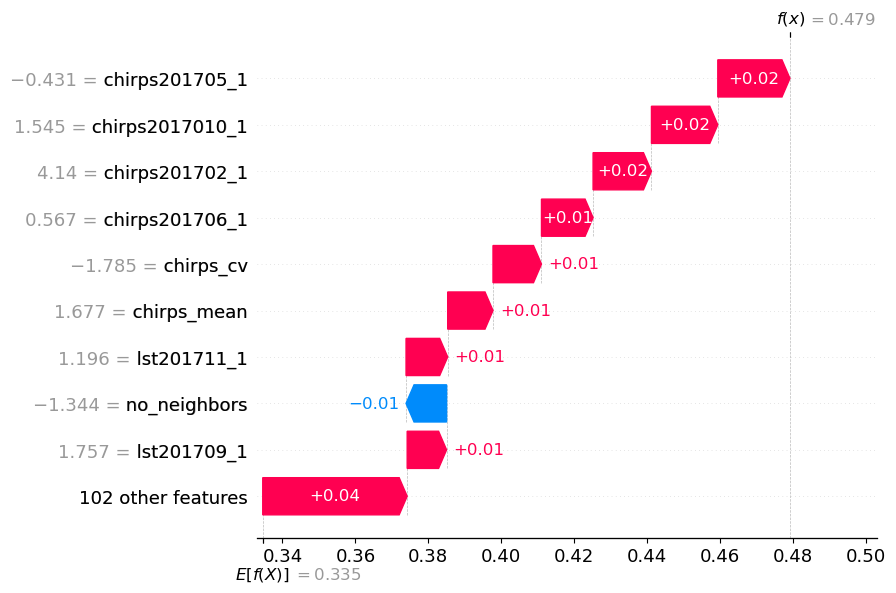

In [59]:
shap.plots.waterfall(deploy_rf_explanation[100, :, 2])

In [60]:
best_rf_model.predict_proba(X_deploy_enc)

array([[0.625     , 0.29166667, 0.08333333],
       [0.82291667, 0.125     , 0.05208333],
       [0.82291667, 0.10416667, 0.07291667],
       ...,
       [0.53480815, 0.42278621, 0.04240563],
       [0.51816279, 0.40527928, 0.07655793],
       [0.54789908, 0.3937946 , 0.05830632]])